In [1]:
import jax.numpy as jnp
from jax import random, grad, jit
from jax.scipy.linalg import inv, svd, eigh, det

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial


key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
num_steps = 100 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples

def create_stable_matrix(n, key):
    # Generate a symmetric random matrix
    A = random.normal(key, (n, n))
    A = (A + A.T) / 2
    
    # Ensure the matrix has a spectral radius < 1 for stability
    eigenvalues, eigenvectors = eigh(A)
    scaled_eigenvalues = eigenvalues / (jnp.abs(eigenvalues).max() + 0.1)  # Scale eigenvalues to ensure stability
    A_stable = eigenvectors @ jnp.diag(scaled_eigenvalues) @ eigenvectors.T
    
    return A_stable

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
q = random.normal(key, (n, n))/5
Q = q@q.T + jnp.eye(n)*0.1#jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 1.0    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
M = create_stable_matrix(n,key)    # State transition matrix (A)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1

# State initialization
vd0 = m0 + random.multivariate_normal(key, jnp.zeros(n), C0)


key, _ = random.split(key)


def state_transition_function(x):
    return jnp.dot(M, x)

def jacobian_function(x):
    return M

jac_func = Partial(jacobian_function)
A_step = Partial(state_transition_function)

In [2]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum
from jax_filters import apply_filtering_fixed_linear, kalman_filter_process
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix

In [3]:
observations, true_states = generate_true_states(key, num_steps, n, vd0, H, Q, R, A_step, observation_interval)

In [4]:
from functools import partial


@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, M, H, Q, R, y, key, N, num_steps, J0):
    states, covariances = apply_filtering_fixed_linear(m0, C0, y, K, n, M, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(states, covariances, n, A_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, states, covariances), y, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost


In [5]:
P = solve_discrete_are(M.T, H.T, Q, R)
# Compute steady-state Kalman gain K
K_steady = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
# print("Steady-state K:")
# print(K_steady)

# Define the gradient of the cost function
var_cost_grad = grad(var_cost, argnums=0)



# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.1
alpha = 1e-5


In [6]:
m, C, K = kalman_filter_process(A_step, jac_func, m0, C0, observations, H, Q, R)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy import linalg as jnpl
from tqdm.auto import tqdm


true_div = []
prediction_errors = [] 
norms = []
Ks = []

n_iters = 500

for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, M, H, Q, R, observations, key, N, num_steps, J0)
    K_opt -= alpha * grad_K
    Ks.append(K_opt)
    # Apply filtering with the newly optimized K to generate state predictions
    predicted_states, covariances = apply_filtering_fixed_linear(m0, C0, observations, K_opt, n, M, H, Q, R)
    prediction_error = np.mean(np.mean((predicted_states - true_states)**2, axis=1))#jnpl.norm(predicted_states - true_states) ** 2 / len(true_states)
    prediction_errors.append(prediction_error)
    norms.append(jnpl.norm(K_opt - K_steady))
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / num_steps)

  0%|          | 0/500 [00:00<?, ?it/s]

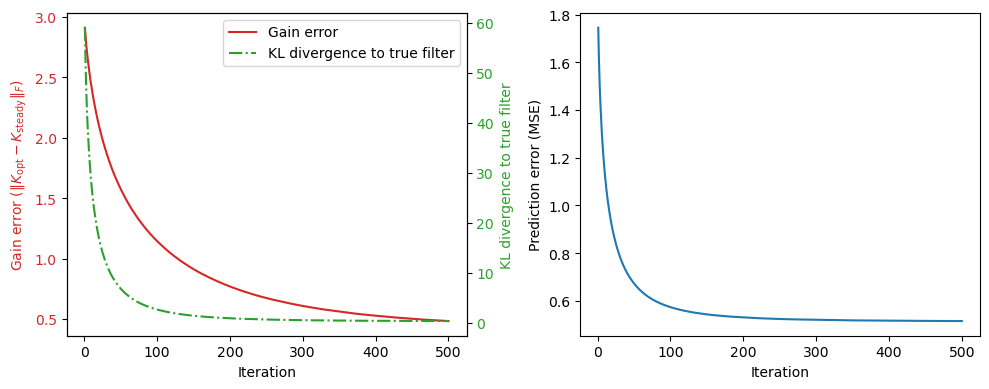

In [21]:
import matplotlib.pyplot as plt

fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

# Optimization Error
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Gain error ($\|K_\mathrm{opt} - K_\mathrm{steady}\|_F$)', color=color)
line1, = ax1.plot(range(1, n_iters+1), norms, label='Gain error', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis for Prediction Error and True Divergence
ax2 = ax1.twinx()
color_pred = 'tab:green'
ax2.set_ylabel('KL divergence to true filter', color=color_pred)
#line1, = ax2.plot(prediction_errors, label='Prediction Error (MSE)', color=color_pred, linestyle='--')
line2, = ax2.plot(range(1, n_iters+1), true_div, label='KL divergence to true filter', color=color_pred, linestyle='-.')
ax2.tick_params(axis='y', labelcolor=color_pred)

# Title and combined legend
#plt.title('Gain errors and KL divergence over iterations')

# Creating a combined legend for all lines
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax3.plot(range(1, n_iters+1), prediction_errors)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (MSE)")

plt.tight_layout()
#plt.show()
plt.savefig("linear_gain.pdf")

Text(0, 0.5, 'Prediction error (MSE)')

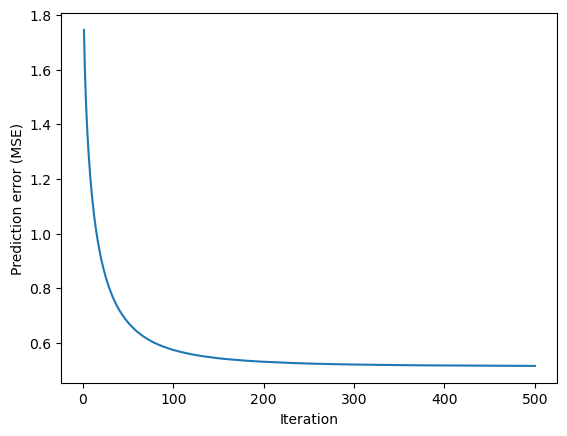

In [9]:
plt.plot(range(1, n_iters+1), prediction_errors)
plt.xlabel("Iteration")
plt.ylabel("Prediction error (MSE)")

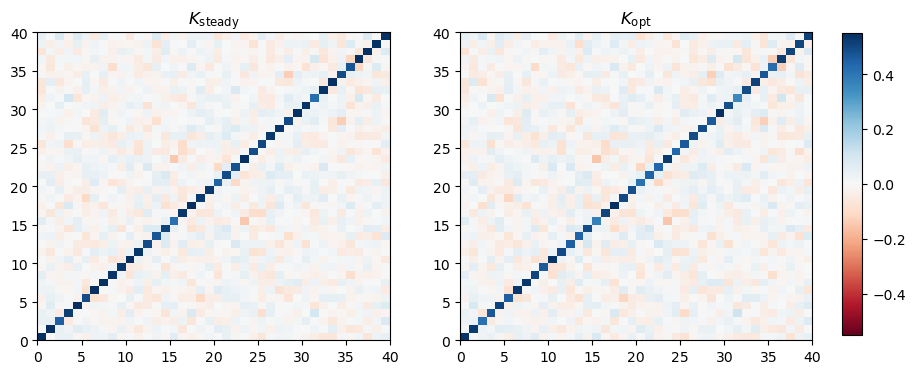

In [41]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.pcolormesh(K_steady, cmap='RdBu', vmax=0.55, vmin=-0.55)
ax1.set_title('$K_\mathrm{steady}$')
p2 = ax2.pcolormesh(K_opt, cmap='RdBu', vmax=0.55, vmin=-0.55)
ax2.set_title('$K_\mathrm{opt}$')
cb_ax = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(p2,orientation='vertical',cax=cb_ax)

plt.savefig("linear_gains.pdf")

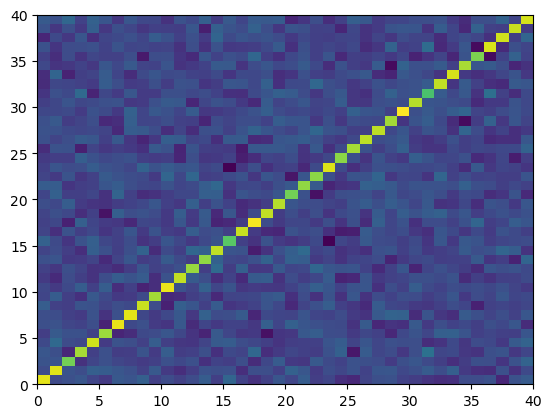

In [11]:
plt.pcolormesh(K_opt)